# Loading and augmenting the data

In [1]:
import glob
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from albumentations import HorizontalFlip, CenterCrop, Rotate

In [2]:
# Creating a directory
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
def load_data(path, split = 0.1):
    # Loading images and masks
    X = sorted(glob(os.path.join(path, "images", "*.jpg")))
    Y = sorted(glob(os.path.join(path, "masks", "*.png")))

    # Spliting data into training and testing
    split_size = int(len(X) * split)
    X_train, X_test = train_test_split(X, test_size = split_size, random_state = 42)
    y_train, y_test = train_test_split(Y, test_size = split_size, random_state = 42)

    return (X_train, X_test), (y_train, y_test)

In [4]:
# Path of data
data_path = "people_segmentation"
(X_train, X_test), (y_train, y_test) = load_data(data_path)

In [5]:
len(X_train), len(y_train), len(X_test), len(y_test)

(5111, 5111, 567, 567)

In [6]:
# Create directories to save augmented data
create_dir("new_data/train/image")
create_dir("new_data/train/mask")
create_dir("new_data/test/image")
create_dir("new_data/test/mask")

In [7]:
def augment_data(images, masks, save_path, augment = True):
    Height = 256
    Width = 256

    for x, y in zip(images, masks):
        # Extract the name of file
        name = x.split("\\")[-1].split(".")[0]

        # Reading the image and mask
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR)

        # Augmenting the data
        if augment:

            # Flipping images horizantaly
            aug = HorizontalFlip(p = 0.2)
            augmented = aug(image = x, mask = y)
            x1 = augmented['image']
            y1 = augmented['mask']

            # Rotating images
            aug = Rotate(p = 1, limit = 45)
            augmented = aug(image = x, mask = y)
            x2 = augmented['image']
            y2 = augmented['mask']

            X = [x, x1, x2]
            Y = [y, y1, y2]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            try:
                # Try center cropping
                aug = CenterCrop(Height, Width, p = 1)
                augmented = aug(image = i, mask = m)
                i = augmented['image']
                m = augmented['mask']

            except Exception as e:
                # If can't center crop then we resize it
                i = cv2.resize(i, (Width, Height))
                m = cv2.resize(m, (Width, Height))

            tmp_image_name = f"{name}_{index}.jpg"
            tmp_mask_name = f"{name}_{index}.jpg"

            image_path = os.path.join(save_path, 'image', tmp_image_name)
            mask_path = os.path.join(save_path, 'mask', tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

In [8]:
# Augmentation
augment_data(X_train, y_train, "new_data/train/", augment=False)
augment_data(X_test, y_test, "new_data/test/", augment=False)

# Building the model

In [9]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def SqueezeAndExcite(inputs, ratio = 8):
    init = inputs
    filters = init.shape[-1]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = init * se

    return x

def ASPP(inputs):
    shape = inputs.shape

    # Image pooling
    y1 = AveragePooling2D(pool_size = (shape[1], shape[2]))(inputs)
    y1 = Conv2D(256, 1, padding = 'same', use_bias = False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation('relu')(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation = 'bilinear')(y1)
    
    # 1x1 conv
    y2 = Conv2D(256, 1, padding = 'same', use_bias = False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation('relu')(y2)

    # 3x3 conv with rate 6
    y3 = Conv2D(256, 3, padding = 'same', use_bias = False, dilation_rate = 6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation('relu')(y3)

    # 3x3 conv with rate 12
    y4 = Conv2D(256, 3, padding = 'same', use_bias = False, dilation_rate = 12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation('relu')(y4)

    # 3x3 conv with rate 18
    y5 = Conv2D(256, 3, padding = 'same', use_bias = False, dilation_rate = 18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation('relu')(y5)

    # Concatenating features
    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(256, 1, padding = 'same', use_bias = False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    return y

def deeplabv3_plus(shape):
    inputs = Input(shape)

    # Encoder
    encoder = ResNet50(weights = 'imagenet', include_top = False, input_tensor = inputs)

    image_features = encoder.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation = 'bilinear')(x_a)
    
    x_b = encoder.get_layer("conv2_block2_out").output
    x_b = Conv2D(48, 1, padding = 'same', use_bias = False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = SqueezeAndExcite(x)

    x = Conv2D(256, 3, padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, 3, padding = 'same', use_bias = False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SqueezeAndExcite(x)

    x = UpSampling2D((4, 4), interpolation = 'bilinear')(x)
    x = Conv2D(1, 1)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs, x)

    return model

# Dataset

In [10]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from metrics import dice_loss, dice_coef, iou

Height = 256
Width = 256

def Shuffling(x, y):
    x, y = shuffle(x, y, random_state = 42)
    
    return x, y

def load_data(path):
    x = sorted(glob(os.path.join(path, 'image', '*.jpg')))
    y = sorted(glob(os.path.join(path, 'mask', '*.jpg')))

    return x, y

def read_image(path):
    path= path.decode()

    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = x / 255.0
    x = x.astype(np.float32)

    return x

def read_mask(path):
    path= path.decode()

    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis = -1)

    return x

def tf_parse(x, y):
    def _parse_(x, y):
        x = read_image(x)
        y = read_mask(y)

        return x, y
    
    x, y = tf.numpy_function(_parse_, [x, y], [tf.float32, tf.float32])
    x.set_shape([Height, Width, 3])
    y.set_shape([Height, Width, 1])

    return x, y

def tf_dataset(X, Y, batch = 2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(15)

    return dataset

create_dir("files")

# Hyperparameters
batch_size = 16
lr = 1e-4
n_epochs = 20
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")

dataset_path = 'new_data'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

x_train, y_train = load_data(train_path)
x_train, y_train = Shuffling(x_train, y_train)

x_test, y_test = load_data(test_path)
x_test, y_test = Shuffling(x_test, y_test)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

train_dataset = tf_dataset(x_train, y_train, batch = batch_size)
valid_dataset = tf_dataset(x_test, y_test, batch  =batch_size)

5111 5111
567 567


# Model

In [11]:
model = deeplabv3_plus((Height, Width, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
model.compile(loss = dice_loss, optimizer = Adam(lr), metrics = [dice_coef, iou, Recall(), Precision()])

In [13]:
callbacks = [
        ModelCheckpoint(model_path, verbose = 0, save_best_only = True),
        ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience = 5, min_lr = 1e-7, verbose = 1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = False),
    ]

In [14]:
model_hist = model.fit(
    train_dataset,
    epochs = n_epochs,
    validation_data = valid_dataset,
    callbacks = callbacks
)

Epoch 1/20
320/320 [==============================] - 117s 328ms/step - loss: 0.1027 - dice_coef: 0.8974 - iou: 0.8171 - recall: 0.9349 - precision: 0.8837 - val_loss: 0.8354 - val_dice_coef: 0.1622 - val_iou: 0.0907 - val_recall: 0.0866 - val_precision: 0.7790 - lr: 1.0000e-04
Epoch 2/20
320/320 [==============================] - 101s 315ms/step - loss: 0.0629 - dice_coef: 0.9371 - iou: 0.8829 - recall: 0.9529 - precision: 0.9277 - val_loss: 0.3147 - val_dice_coef: 0.6818 - val_iou: 0.5240 - val_recall: 0.5558 - val_precision: 0.9021 - lr: 1.0000e-04
Epoch 3/20
320/320 [==============================] - 100s 313ms/step - loss: 0.0472 - dice_coef: 0.9529 - iou: 0.9110 - recall: 0.9667 - precision: 0.9441 - val_loss: 0.0705 - val_dice_coef: 0.9297 - val_iou: 0.8694 - val_recall: 0.9353 - val_precision: 0.9292 - lr: 1.0000e-04
Epoch 4/20
320/320 [==============================] - 101s 316ms/step - loss: 0.0366 - dice_coef: 0.9634 - iou: 0.9301 - recall: 0.9750 - precision: 0.9558 - val_l

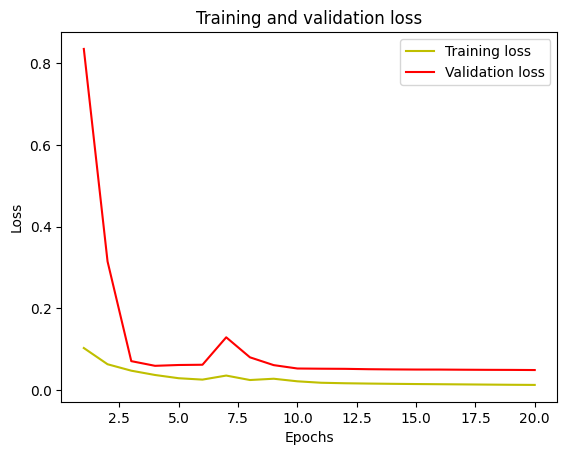

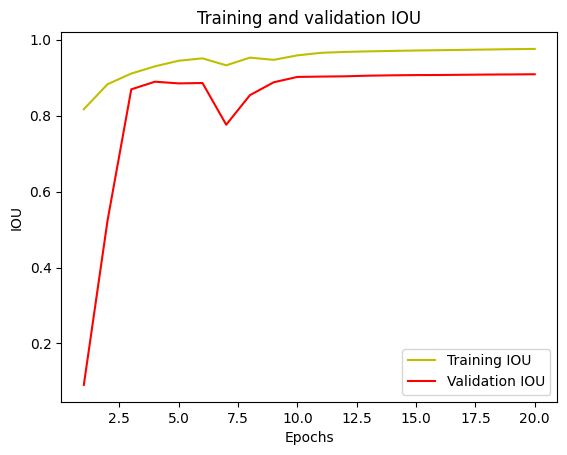

In [16]:
import matplotlib.pyplot as plt

loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = model_hist.history['iou']
val_acc = model_hist.history['val_iou']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

# Evaluation

In [17]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.utils import CustomObjectScope

with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("files/model.h5")

In [18]:
create_dir("results")

dataset_path = "new_data"
valid_path = os.path.join(dataset_path, "test")
x_test, y_test = load_data(valid_path)
print(f"Test: {len(x_test)} - {len(x_test)}")

Test: 567 - 567


In [30]:
import pandas as pd

def save_results(image, mask, y_pred, save_image_path):
    ## i - m - yp - yp*i
    line = np.ones((Height, 10, 3)) * 128

    mask = np.expand_dims(mask, axis=-1)    # (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    mask = mask * 255

    y_pred = np.expand_dims(y_pred, axis=-1)    # (512, 512, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)  # (512, 512, 3)

    masked_image = image * y_pred
    y_pred = y_pred * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred, line, masked_image], axis=1)
    cv2.imwrite(save_image_path, cat_images)

SCORE = []
for x, y in zip(x_test, y_test):
        " Extract the name "
        name = x.split("\\")[-1].split(".")[0]

        " Reading the image "
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        x = image/255.0
        x = np.expand_dims(x, axis=0)

        " Reading the mask "
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)

        " Prediction "
        y_pred = model.predict(x)[0]
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred > 0.5
        y_pred = y_pred.astype(np.int32)

        " Saving the prediction "
        save_image_path = f"results\{name}.jpg"
        save_results(image, mask, y_pred, save_image_path)

1/1 [==============================] - 0s 34ms/step
